In [2]:
library(magrittr)
library(tidyverse)
library(patchwork)
library(pheatmap)

In [3]:
data <- read.table(here::here("data", "mesoscale", "231013_Mesoscale_values.csv"), sep=",",header=TRUE, skip = 1)

In [4]:
names_to_well <- read.table(here::here("data", "mesoscale", "230912_Mesoscale_name_to_well.tsv"), sep="\t")
colnames(names_to_well) <- c("code number", "V2", "Well")
names_to_well %<>% select(`code number`, Well)

In [5]:
ann <- readxl::read_xlsx(here::here("data", "mesoscale", "230912_Mesoscale_annotation.xlsx"))
ann %<>% rename("Treatment"=Sample)

In [8]:
data_plot <- data %>% left_join(names_to_well) %>% left_join(ann) %>% 
    arrange(Patient, Time, Treatment) %>% 
    mutate(Plate_short=gsub(".*_([A-Za-z0-9]+)_[0-9]+$", "\\1", Plate.Name),
           Target=paste(Plate_short, Assay, sep="_"),
           volume=ifelse(is.na(`Volume of supernatant`), 300, `Volume of supernatant`),
           factor=volume/300,
           conc=log10(Calc..Concentration),
           input=paste(Patient,Treatment,Time,sep="_") %>% gsub("_NA", "", .)
          ) %>% 
    filter(!is.na(Patient))

Joining with `by = join_by(Well)`
Joining with `by = join_by(`code number`)`


In [9]:
data_plot_nobg <- data_plot %>% 
    select(input, Target, conc=Calc..Concentration) %>% 
    pivot_wider(names_from="input", id_cols="Target", values_from="conc") %>% 
    #select(input, Target, conc) %>% 
    #pivot_wider(names_from="input", id_cols="Target", values_from="conc") %>% 
    column_to_rownames("Target") %>% as.matrix()

data_plot_nobg[, grepl("P28|P35", colnames(data_plot_nobg))] <- data_plot_nobg[, grepl("P28|P35", colnames(data_plot_nobg))]*2

data_plot_nobg[is.nan(data_plot_nobg)] <- 0
data_plot_nobg <- data_plot_nobg-data_plot_nobg[, 1]

data_plot_nobg[data_plot_nobg < 0] <- 0
data_plot_nobg %<>% log10()
data_plot_nobg[data_plot_nobg == -Inf] <- NA
data_plot_nobg[is.na(data_plot_nobg)] <- min(data_plot_nobg, na.rm = TRUE)-0.5
data_plot_nobg <- data_plot_nobg[,-c(1:2)]

val_max <- quantile(data_plot_nobg, probs=0.97, na.rm=TRUE)
data_plot_nobg[data_plot_nobg > val_max] <- val_max 

data_plot_nobg %<>% .[!grepl("Vascu2_", rownames(.)), grepl("P22", colnames(.))]

Warning message in strwidth(t, units = "in", cex = fontsize_col/fontsize):
“conversion failure on 'Pro1_IFN-γ' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in strwidth(t, units = "in", cex = fontsize_col/fontsize):
“conversion failure on 'Pro1_IFN-γ' in 'mbcsToSbcs': dot substituted for <b3>”
Warning message in strwidth(t, units = "in", cex = fontsize_col/fontsize):
“conversion failure on 'Chem1_MIP-1α' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in strwidth(t, units = "in", cex = fontsize_col/fontsize):
“conversion failure on 'Chem1_MIP-1α' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in strwidth(t, units = "in", cex = fontsize_col/fontsize):
“conversion failure on 'Chem1_MIP-1β' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in strwidth(t, units = "in", cex = fontsize_col/fontsize):
“conversion failure on 'Chem1_MIP-1β' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in strwidth(t, units = "in", cex = fontsize_col/font

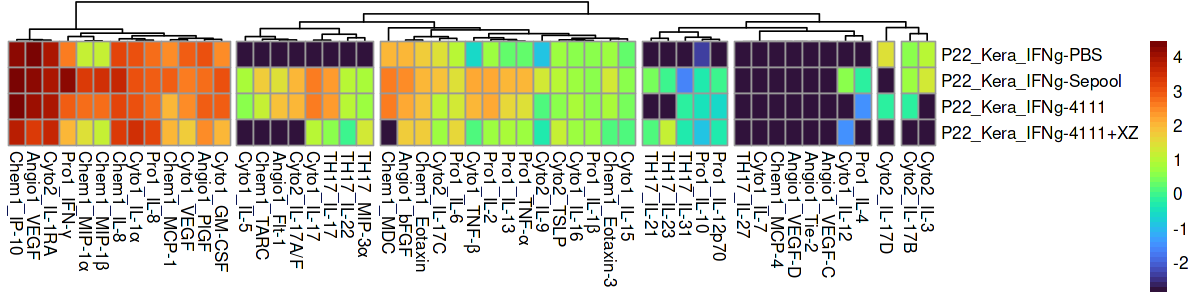

In [13]:
options(repr.plot.width=10, repr.plot.height=2.5)

data_plot_nobg[, c(3,4,1,2)] %>% t() %>% 
    pheatmap(cluster_cols=TRUE, cluster_rows=FALSE, cutree_cols=7, treeheight_col=20, #gaps_col=gaps[-c(1:2)]-6,
             color=viridisLite::turbo(50))